# MAP553 Kaggle challenge - Forest cover type
---
author : Rémi Grzeczkowicz
mail : [remi.grzeczkowicz@polytechnique.edu](mailto:remi.grzeczkowicz@polytechnique.edu)

___
## Table des matières
1. [Introduction](#intro)
2. [Import data](#import)
3. [Data exploration](#explore)
4. [Data preprocessing](#preprocess)
5. [Model selection](#model)
6. [Prediction](#predict)
7. [Conclusion](#conclusion)


---
## 1. Introduction <a name="intro"></a>
The aim of the challenge is to predict the forest cover type. 

In [2]:
### Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import os
from tqdm import tqdm
import sklearn

In [3]:
print('Python: {}'.format(sys.version))  # Python version
print('numpy: {}'.format(np.__version__))  # Numpy version
print('pandas: {}'.format(pd.__version__))  # Pandas version
print('seaborn: {}'.format(sns.__version__))  # seaborn version
print('sklearn: {}'.format(sklearn.__version__))  # sklearn version

Python: 3.11.7 (main, Dec  4 2023, 18:10:11) [Clang 15.0.0 (clang-1500.1.0.2.5)]
numpy: 1.26.2
pandas: 1.5.3
seaborn: 0.13.0
sklearn: 1.3.2


In [4]:
# Removing warnings
import warnings
warnings.filterwarnings('ignore')


In [5]:
### Generate the submission file
def generating_submission_csv(prediction, name=""):
    data = {'Id': [k+1 for k in range(len(prediction))], 'Cover_type': prediction}

    # Create DataFrame from dictionary
    predictions_df = pd.DataFrame(data)

    # Save to csv
    predictions_df.to_csv('predictions_'+name+'.csv', index=False)

---
## 2. Import data <a name="import"></a>

In [6]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test-full.csv')

In [7]:
train_data.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,242642,2881,130,22,210,54,1020,250,221,88,...,0,0,0,0,0,0,0,0,0,1
1,309891,3005,351,14,242,-16,1371,194,215,159,...,0,0,0,0,0,0,0,0,0,1
2,287847,3226,63,14,618,2,1092,232,210,107,...,0,0,0,0,0,0,0,0,0,1
3,516307,3298,317,8,661,60,752,198,233,174,...,0,0,0,0,0,0,0,0,0,1
4,124860,3080,35,6,175,26,3705,219,227,144,...,0,0,0,0,0,0,0,0,0,1


In [8]:
shape = train_data.shape
print("The train dataset contains {} rows and {} columns.".format(shape[0], shape[1]))

The train dataset contains 15120 rows and 56 columns.


In [9]:
shape = test_data.shape
print("The test dataset contains {} rows and {} columns.".format(shape[0], shape[1]))

The test dataset contains 581012 rows and 55 columns.


In [10]:
# Remove the Id column and cover type column
id_train = train_data['Id']
cover_type_train = train_data['Cover_Type']
id_test = test_data['Id']
train_data.drop(['Id', 'Cover_Type'], axis=1, inplace=True)
test_data.drop(['Id'], axis=1, inplace=True)

In [11]:
train_numerical_features = train_data.iloc[:, :10]

---
## 3. Data exploration <a name="explore"></a>

### 3.1. Features spread

Text(0, 0.5, 'Features')

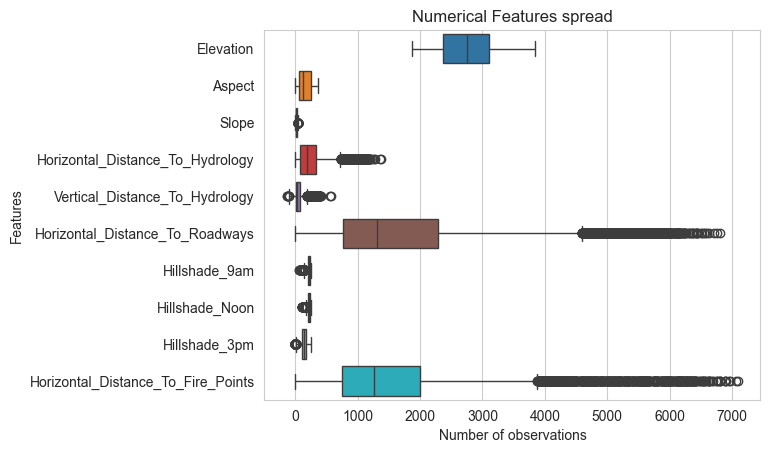

In [13]:
sns.set_style("whitegrid")
sns.boxplot(data = train_numerical_features, orient='h')
plt.title("Numerical Features spread")
plt.xlabel("Number of observations")
plt.ylabel("Features")

Elevation and aspect are the two features that does not seem to have outliers. 
Slope is the most squeezed feature.
Hillshade features without their outliers are quite similar to slope.

### 3.2. Categorical distribution

#### 3.2.1. Cover type

Text(0, 0.5, 'Number of observations')

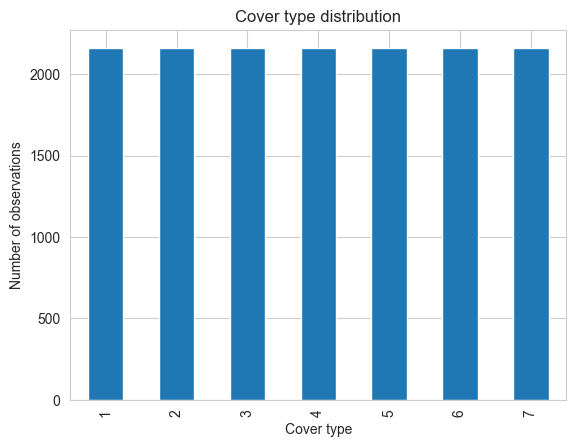

In [15]:
cover_type_train.value_counts().plot(kind='bar', title='Cover type distribution')
plt.xlabel("Cover type")
plt.ylabel("Number of observations")

The dataset is balanced with respect to the cover type. This means we do not have to rebalance it.

#### 3.2.2. Wilderness area

Text(0, 0.5, 'Number of observations')

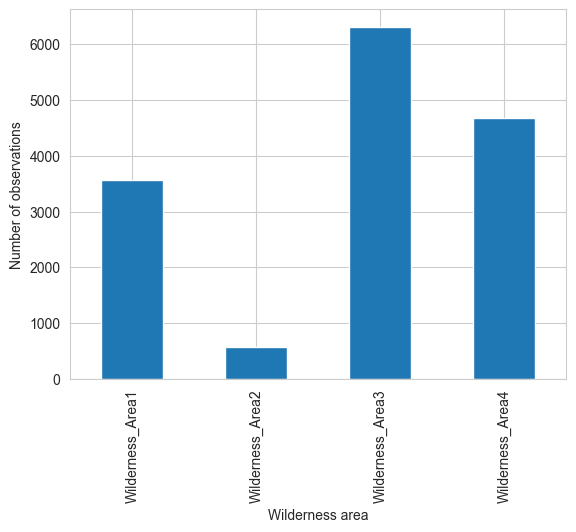

In [19]:
wilderness_area = train_data.iloc[:, 10:14]
wilderness_area.sum().plot(kind='bar')
plt.xlabel("Wilderness area")
plt.ylabel("Number of observations")


Wilderness area is not balanced

#### 3.2.3. Soil type

Text(0, 0.5, 'Number of observations')

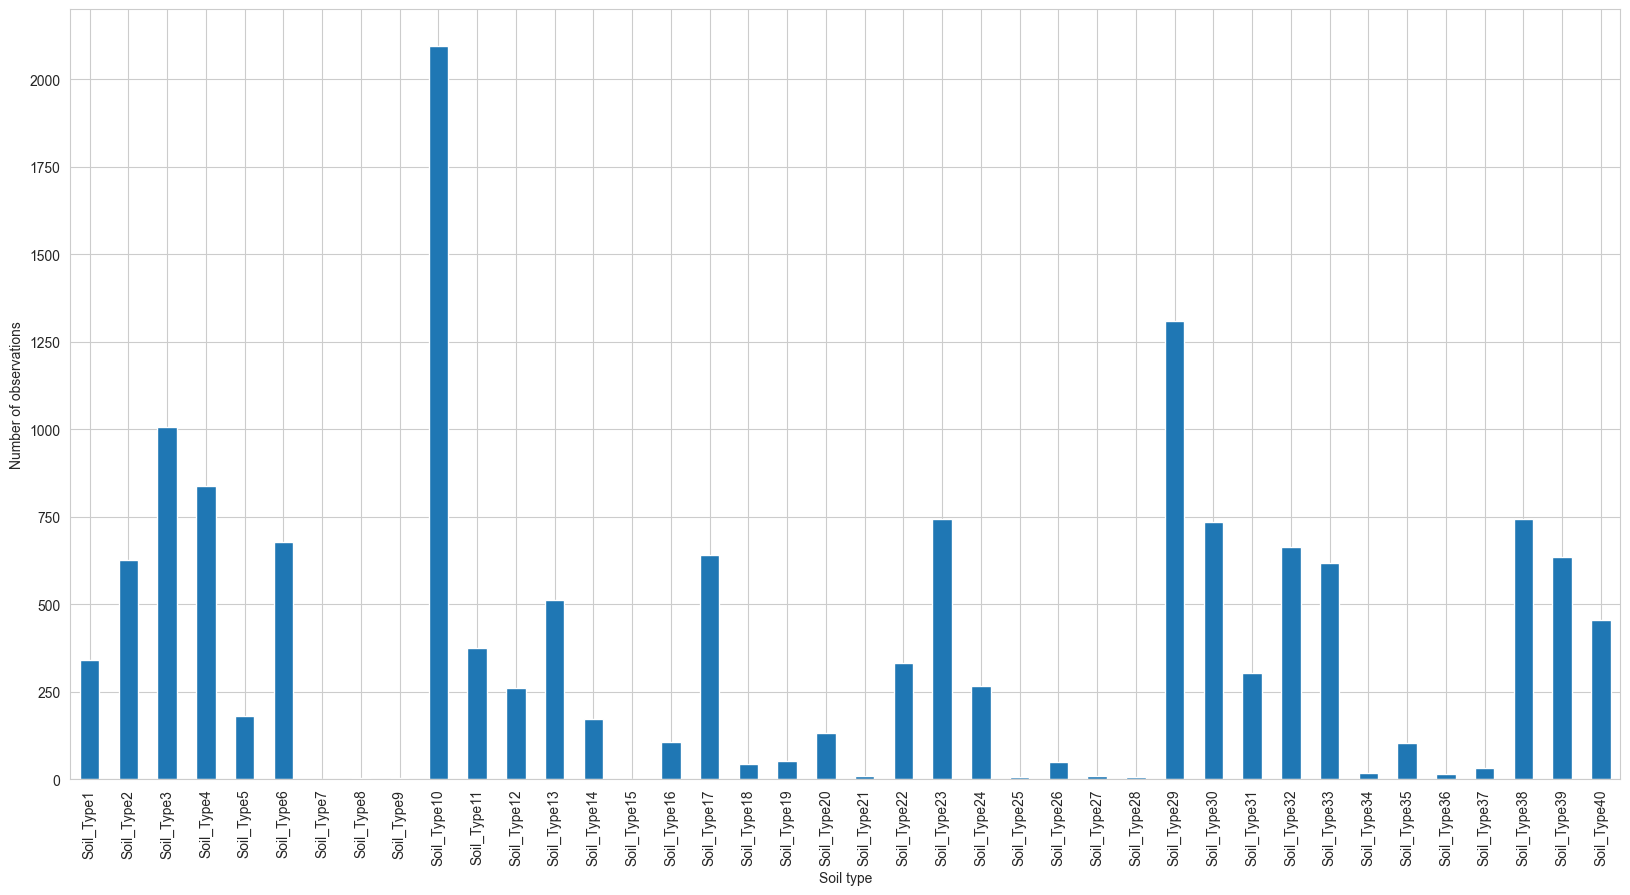

In [22]:
sol_type = train_data.iloc[:, 14:]
sol_type.sum().plot(kind='bar', figsize=(20, 10))
plt.xlabel("Soil type")
plt.ylabel("Number of observations")

Soil type is absolutely not balanced with high peaks for some soil types and almost no observations for others.

### 3.3. Correlation with cover type

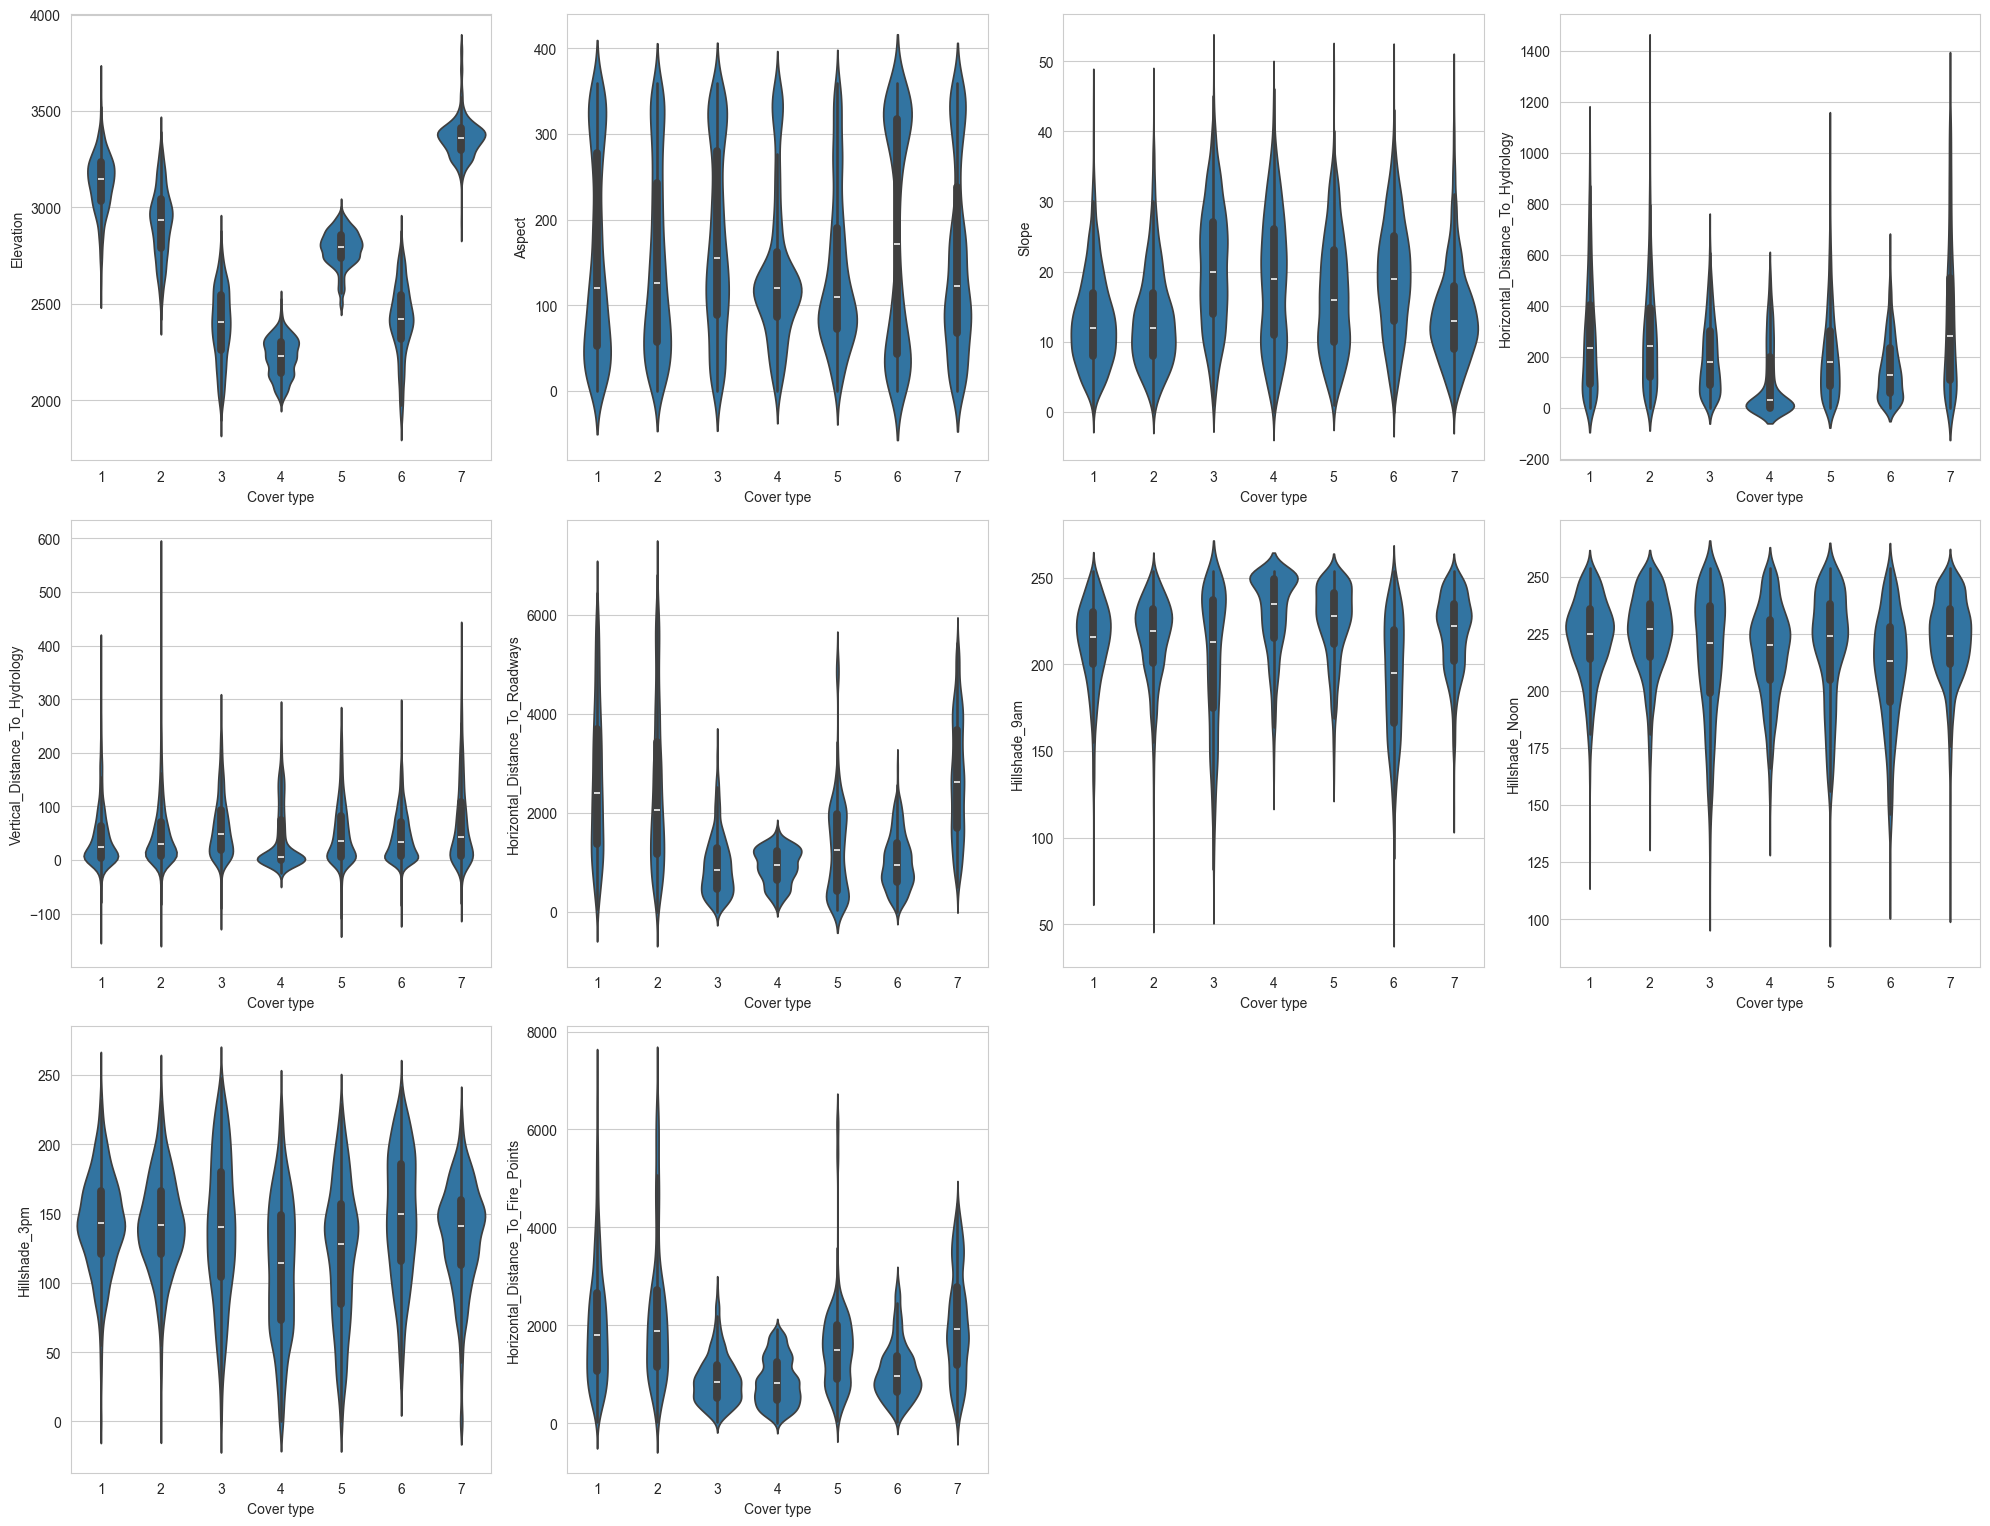

In [36]:
# Let's plot violin plots for each feature with respect to the cover type
plt.figure(figsize=(20, 20))
for i in range(len(train_numerical_features.columns)):
    features = train_numerical_features.columns[i]
    plt.subplot(4, 4, i+1)
    sns.violinplot(x=cover_type_train, y=features, data=train_data)
    plt.xlabel("Cover type")
    plt.ylabel(features)
plt.tight_layout()